# Diffusion Model Guidance


HHU Deep Learning in Life Science: Generative Models, Prof. Dr. **Markus Kollmann**, WS 2025-2026

Tutors: **Felix Michels** and **Adaloglou Nikolaos**
## Assignment 4 - Diffusion Model Guidance

- **Submission  [link](https://uni-duesseldorf.sciebo.de/s/bmAyQY3a8z82wGk)**
- **Deadline**: 11/12/2025 14:30 CET (1-week exercise)
- **Note**: `Rename` your file BEFORE submitting!
- If you encounter issues that might apply to other students, please notify others in the group chat.

#### How to submit
- Submit the solved notebook (not a zip) with your full name (`NAME_SURNAME`) plus assignment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for `assignment 1`. If you have more names, please use only the first one for all homeworks.
- Please use the same naming convention `NAME_SURNAME_aX` to facilitate the tutors.
- You are free to modify our code as you see fit.
---

This exercise is based on a toy model and code by Tim Kaiser, which will help us understand classifier-free guidance (CFG) and "Weak model guidance" (WMG) in diffusion models (details in appendix B of [[1]](https://arxiv.org/pdf/2411.10257)).

In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

from utils import t_schedule, y_star, full_grid, plot_geom_analysis

## Preliminaries
$\boldsymbol{y} \in \mathbb{R}^d$ is a data point (i.e., from the target distribution) and
$\boldsymbol{x} \coloneqq \boldsymbol{x}(t) \in \mathbb{R}^d$ is a noise dependent point along the denoising trajectory, with conditional pdf
$p(\boldsymbol{x}|\boldsymbol{y}, \sigma) = \mathcal{N}(\boldsymbol{x}|\boldsymbol{y}, \sigma(t)^2 \mathbf{I})$, where $\sigma(0) = 0$ and $\sigma(1) \gg \operatorname{std}(\boldsymbol{y})$.

The optimal denoising function $\boldsymbol{y}^*(\boldsymbol{x}, \sigma)$ is given by
$$
\boldsymbol{y}^*(\boldsymbol{x}, \sigma) = \int \boldsymbol{y} \; p(\boldsymbol{y}|\boldsymbol{x}, \sigma) \mathrm{d}\boldsymbol{y}
= \int \boldsymbol{y} \frac{p(\boldsymbol{x}|\boldsymbol{y}, \sigma) p(\boldsymbol{y})}{p(\boldsymbol{x}|\sigma)} \mathrm{d}\boldsymbol{y}. \tag{1}
$$

## Toy Example
In the toy example we have a finite set of three data points $\{\boldsymbol{y}_i\}$, with uniform prior $p(\boldsymbol{y}_i) = \frac{1}{3}$.
The optimal denoising function $\boldsymbol{y}^*(\boldsymbol{x}, \sigma)$ from (1) becomes

$$
\boldsymbol{y}^*(\boldsymbol{x}, \sigma) = \frac
{\sum_i \boldsymbol{y}_i \mathcal{N}(\boldsymbol{x}|\boldsymbol{y}_i, \sigma^2 \mathbf{I})}
{\sum_i \mathcal{N}(\boldsymbol{x}|\boldsymbol{y}_i, \sigma^2 \mathbf{I})}. \tag{2}
$$

To view this as a conditioning problem, we can assign each data point a class label $c_i \in \{1,2,3\}$.
The optimal denoising function conditioned on class $c$ is simply
$$
\boldsymbol{y}^*(\boldsymbol{x}, \sigma; c) = \boldsymbol{y}_c. \tag{3}
$$

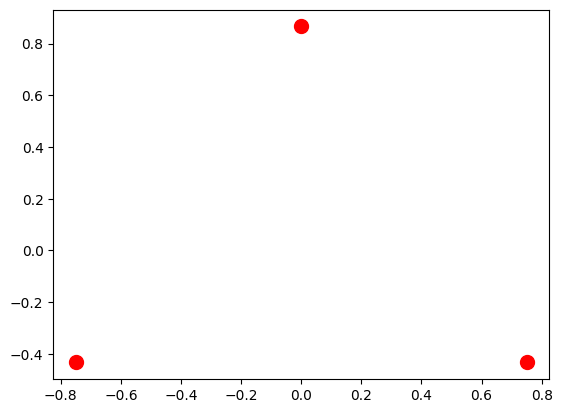

In [3]:
# Triangle
data = np.array([[0, 0], [2, 0], [1, 1.73205]])
data -= np.array([1, 0.57735])
data *= 0.75

# Setup
dim = data.shape[1]
num_steps, sigma_min, sigma_max, rho = 40, 2e-3, 80, 7
t_steps = t_schedule(num_steps, sigma_min, sigma_max, rho)

plt.scatter(data[:, 0], data[:, 1], c="red", s=100, label="Data points");

Expected results:

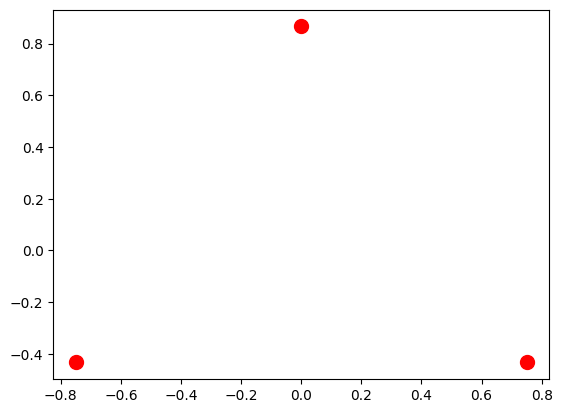



## Error-prone denoiser
The optimal denoising function from (2) needs no guidance and is not available in practice.
To simulate an error-prone denoiser, we add Gaussian noise with standard deviation $\delta$ to our data points.
The prior is the mixture model $p_\delta(\boldsymbol{y}) = \frac{1}{3} \sum_i \mathcal{N}(\boldsymbol{y}|\boldsymbol{y}_i, \delta^2 \mathbf{I})$
and it turns out that the corresponding denoising function is given by
$$
\boldsymbol{y}_\delta(\boldsymbol{x}, \sigma) = \frac
{\boldsymbol{x}\delta^2 + \boldsymbol{y}^* (\boldsymbol{x}, \tilde\sigma) \sigma^2}
{\tilde{\sigma}^2}, \quad \text{where} \quad \tilde\sigma = \sqrt{\sigma^2 + \delta^2}. \tag{4}
$$
The conditional case is analogously
$$
\boldsymbol{y}_\delta(\boldsymbol{x}, \sigma; c) = \frac
{\boldsymbol{x}\delta^2 + \boldsymbol{y}^* (\boldsymbol{x}, \tilde\sigma; c) \sigma^2}
{\tilde{\sigma}^2}. \tag{5}
$$

Implement (4) and (5) in the function `y_toy` below.
Use the function `y_star` from `utils.py`, which implements a stable version of (2).

In [29]:
def y_toy(x, t, c, data, delta, cond):
    """
    Error-prone prediction y_delta.
    Args:
        x: Current point in the trajectory x(t)
        t: Current noise level sigma(t)
        c: class label. Ignored if cond=False
        data: All data points y_i
        delta: Uncertainty around the data points
        cond: Whether to condition on class label c

    Returns:
        np.ndarray: The prediction y_delta
    """
    c = c % data.shape[0]
    ### START CODE HERE ###
    if cond:
        first_term = x * delta**2
        
        sigma_tilde_sq = t**2 + delta**2
        y_star_point = data[c]
        second_term = y_star_point * t**2
        
        whole_term = (first_term + second_term) / sigma_tilde_sq
        return whole_term
    else:
        first_term = x * delta**2
        
        sigma_tilde_sq = t**2 + delta**2
        y_star_point = y_star(x, sigma_tilde_sq, data)
        second_term = y_star_point * t**2
        
        whole_term = (first_term + second_term) / sigma_tilde_sq
        return whole_term
    ### END CODE HERE ###

## Classifier-Free Guidance

Classifier-free guidance (CFG) [[2]](https://arxiv.org/abs/2207.12598) combines a class conditional noise predictor $\varepsilon(\boldsymbol{x}, t; c)$
and an unconditional noise predictor $\epsilon(\boldsymbol{x}, t)$ via
$$
\tilde{\varepsilon}(\boldsymbol{x}, t; c) \coloneqq \varepsilon(\boldsymbol{x}, t; c) + w \left( \varepsilon(\boldsymbol{x}, t; c) - \varepsilon(\boldsymbol{x}, t) \right), \tag{6}
$$
where $w \geq 0$ is the guidance weight.
CFG reduces class mismatch between samples and the conditioning label, but can lead to overall reduced diversity or oversaturated images by "overshooting" the desired distribution.
Additionally, training a conditional and an unconditional model can be computationally expensive.

## Weak Model Guidance
Another class of guidance methods (which we refer to as "Weak Model Guidance" (WMG)) uses a weak model to guide the sampling of a stronger model.
$$
\tilde{\varepsilon}(\boldsymbol{x}, t)
\coloneqq \varepsilon_{\text{pos}}(\boldsymbol{x}, t) + w \left( \varepsilon_{\text{pos}}(\boldsymbol{x}, t) - \varepsilon_{\text{neg}}(\boldsymbol{x}, t) \right). \tag{7}
$$
Here $\varepsilon_{\text{pos}}$ is a strong model (i.e., low $\delta$ in the toy model) and $\varepsilon_{\text{neg}}$ is a weak model (i.e., high $\delta$).
`pos` and `neg` just refer to the positive and negative contribution of the guidance, respectively.

For WMG we can find the "optimal" guidance weight $w^*$ by essentially setting eq. (7) equal to $\varepsilon^*(\boldsymbol{x}, t)$ and solving for $w$:
$$
w^*(\boldsymbol{x}, t) =
\frac{\|\varepsilon^*(\boldsymbol{x}, t) - \varepsilon_{\text{pos}}(\boldsymbol{x}, t)\|_2}
{\|\varepsilon_{\text{pos}}(\boldsymbol{x}, t) - \varepsilon_{\text{neg}}(\boldsymbol{x}, t)\|_2}.
\tag{8}
$$
(add a small constant like $10^{-128}$ to the denominator for numerical stability).

Since equations (6) and (7) have the same form, "positive model" in the following code refers to either the conditional model in CFG or the strong model in WMG,
while "negative model" refers to either the unconditional model in CFG or the weak model in WMG.

The toy model function `y_toy` doesn't predict noise $\varepsilon$, but the denoised point $\boldsymbol{y} = \boldsymbol{x} - t \varepsilon$,
but that just means we have to use $\boldsymbol{y}$ instead of $\varepsilon$ in the equations above ($\boldsymbol{x}$ cancels out).

Implement the `compute_score` function using the `y_toy` function with different parameters for the positive and negative model.

## Classifier Guidance

For completeness' sake let's review the original guidance using a classifier [[3]](https://arxiv.org/pdf/2105.05233).
There we use an additional classifier $p(c|\boldsymbol{x}, \sigma)$ trained *on all noise levels* and use the noise predictor
$$
\begin{aligned}
\tilde{\varepsilon}(\boldsymbol{x}, t; c)
&\coloneqq \varepsilon(\boldsymbol{x}, t; c) -w\sigma\nabla_x \log p(c|x, \sigma)\\
&= \underbrace{\varepsilon(\boldsymbol{x}, t; c)}_{=\varepsilon_\text{pos}} + w\left(
\underbrace{\varepsilon(\boldsymbol{x}, t; c)}_{=\varepsilon_\text{pos}}
- \underbrace{(\varepsilon(\boldsymbol{x}, t; c) + \sigma\nabla_x \log p(c|x, \sigma)))}_{=\varepsilon_\text{neg}}
\right).
\end{aligned}
$$
The second line is just to show the correspondence to CFG and WMG.

In [30]:
def compute_score(x, t, i, c, guid_weight, interval, data, pos_kwargs, neg_kwargs):
    """
    Compute the score function at the point x and time t.
    Args:
        x: Current point in the trajectory x(t)
        t: Current noise level sigma(t)
        i: Current time step
        c: class label. Ignored if pos_kwargs['cond']=False
        guid_weight: Guidance weight (float) or 'opt_weight'
        interval: (sorted list) Interval of time steps
            where the guidance weight is used.
        data: All data points
        pos_kwargs: Positive model parameters (delta and cond)
        neg_kwargs: Negative model parameters (delta and cond)

    Returns:
        np.ndarray: The score function at x and t
        np.ndarray: The prediction y(t)
        np.ndarray: The positive model prediction y_pos
        np.ndarray: The negative model prediction y_neg
        float: The guidance weight. If step i is outside of interval, returns 0.
            Otherwise, if guid_weight is 'opt_weight', returns the optimal weight from (8). (remember that the optimal model is conditional if pos_kwargs['cond']=True)
            Otherwise, if guid_weight is a float, returns that float.
    """
    c = c % data.shape[0]
    ### START CODE HERE ###
    y_pos = y_toy(x, t, c, data, pos_kwargs['delta'], pos_kwargs['cond'])
    
    y_neg = y_toy(x, t, c, data, neg_kwargs['delta'], neg_kwargs['cond'])
    
    if i not in interval:
        w = 0
        y_pred = y_pos
    else:
        if guid_weight == 'opt_weight':
            if pos_kwargs['cond']:
                y_optimal = data[c]  
            else:
                t_sq = t ** 2
                y_optimal = y_star(x, t_sq, data)  
            
            numerator = norm(y_optimal - y_pos)
            denominator = norm(y_pos - y_neg) + 1e-128  
            w = numerator / denominator
        else:
            w = guid_weight
        
        y_pred = y_pos + w * (y_pos - y_neg)
    
    ### END CODE HERE ###
    d_cur = (x - y_pred) / t  # score = force / t^2
    return d_cur, y_pred, y_pos, y_neg, w


The following code will compute and plot multiple denoising trajectories.
The rows from top to bottom depict:
1. Optimal denoising function from (2) without guidance.
2. Guidance combination of positive and negative model (either (6) or (7)).
3. Just the positive model.
4. Just the negative model.

The columns from left to right are:
1. The trajectory $\boldsymbol{x}(t)$.
2. The denoised prediction $\boldsymbol{y}(\boldsymbol{x}(t), \sigma(t))$.
3. The final sample $\boldsymbol{x}(0)$.
4. The error $\|\boldsymbol{y}(t) - \boldsymbol{y}^*(\boldsymbol{x}(t), \sigma(t))\|$ over time.

First we try WMG with positive model $\delta_{\text{pos}} = 0.1$ and negative model $\delta_{\text{neg}} = 0.3$.

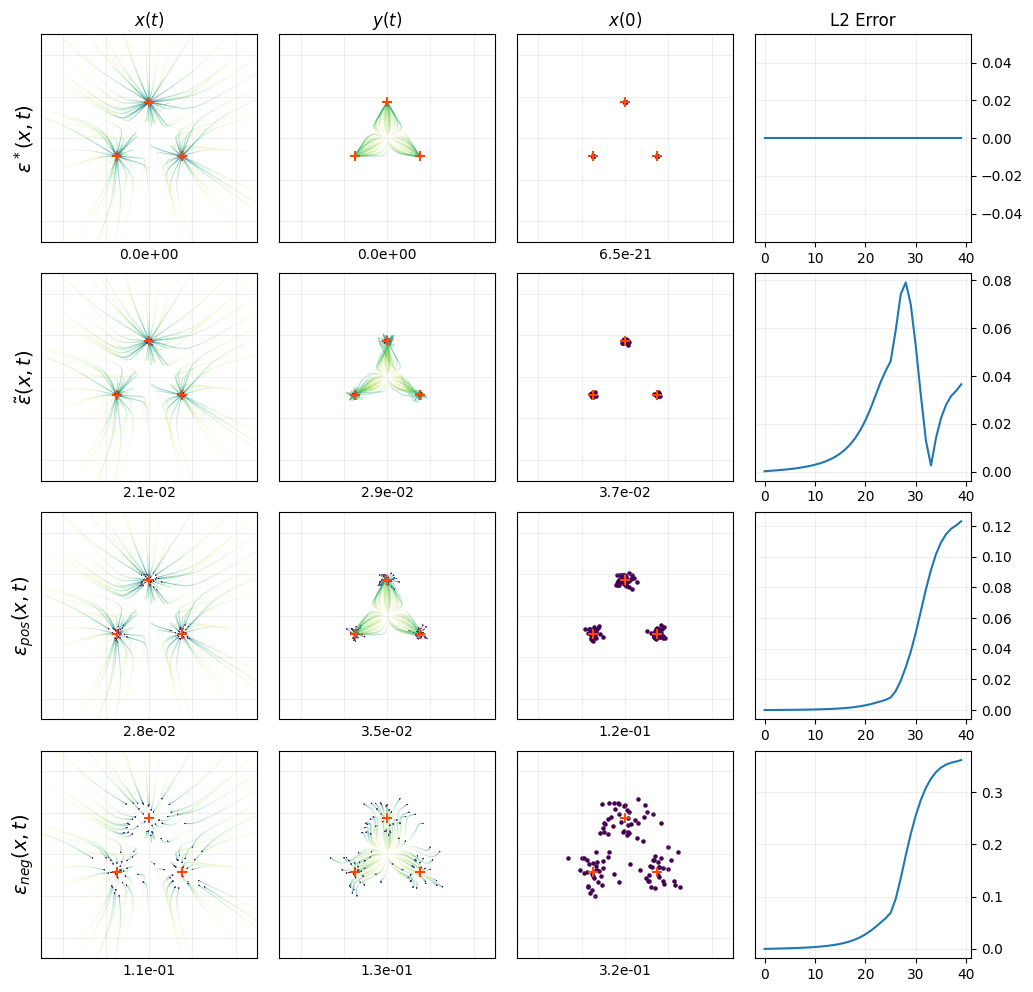

In [31]:
# Setup
step_kwargs = {'sigma_min': 2e-3, 'sigma_max': 80, 'rho': 7}

kwargs = {
    'pos_kwargs': {"delta": 1e-1, "cond": False},  # positive network
    'neg_kwargs': {"delta": 3e-1, "cond": False},  # negative network
    'guid_weight': 1
}


num_steps = 40
full_grid(
    data,
    t_steps=t_schedule(num_steps=num_steps, **step_kwargs),
    interval=list(range(num_steps)),
    score_fn=compute_score,
    **kwargs
);

Expected results:

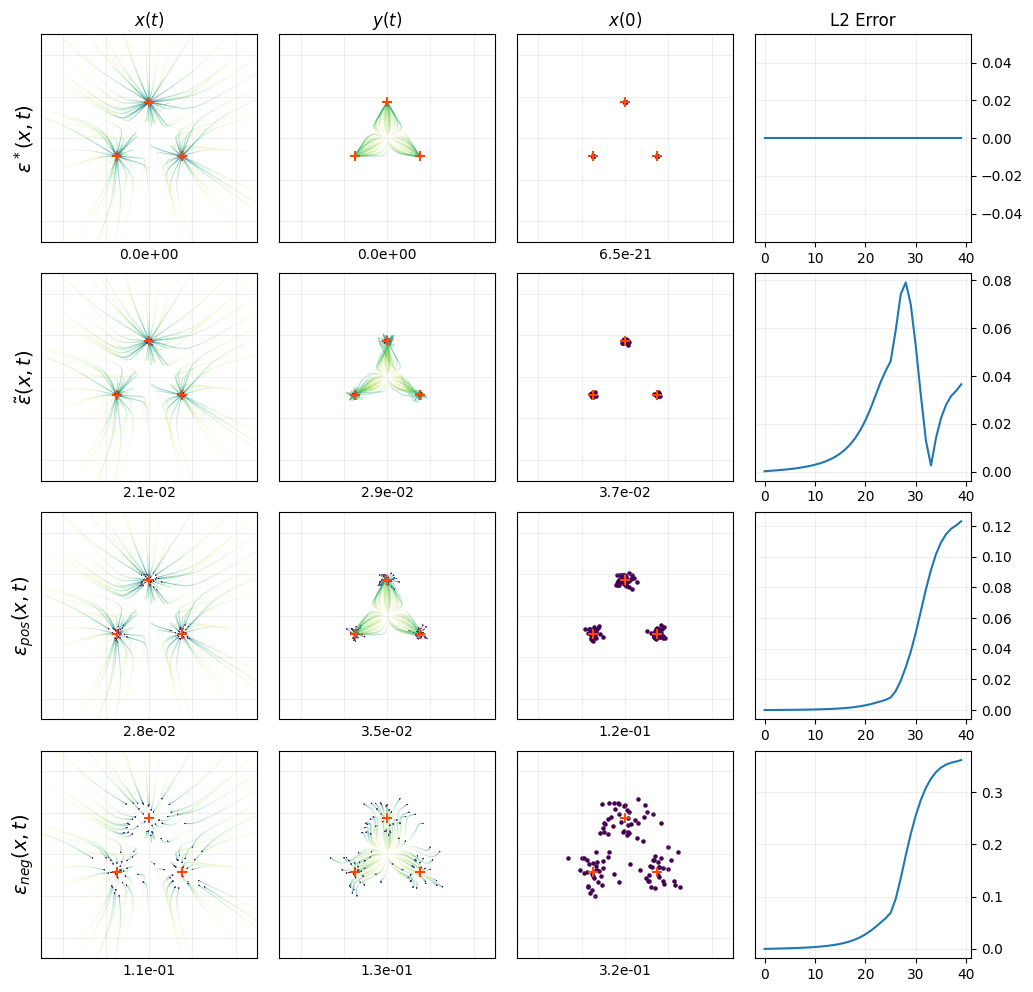



Next we'll take a closer look at a single trajectory at one step to see how the negative model pushes the prediction towards the optimal one.

What would happen, if the negative model were closer than the positive model, i.e.,
$$
\|
\varepsilon_\text{neg}(\boldsymbol{x}, t) - \varepsilon^*(\boldsymbol{x}, t)
\|_2
<
\|
\varepsilon_\text{pos}(\boldsymbol{x}, t) - \varepsilon^*(\boldsymbol{x}, t)
\|_2
\text{ ?}
$$

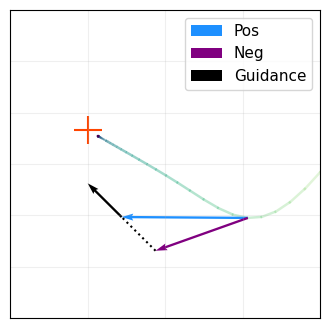

In [32]:
num_steps = 120
plot_geom_analysis(
    data,
    t_steps=t_schedule(num_steps=num_steps, **step_kwargs),
    interval=list(range(num_steps)),
    score_fn=compute_score,
    **kwargs
)

Expected results:

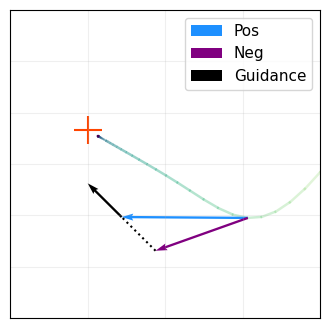



Repeat the two plots for
- WMG with $\delta_\text{pos}=0.1$, $\delta_\text{neg}=0.2$ and using the optimal weight via `guid_weight='opt_weight'`
- CFG with $\delta=0.1$

What do you observe?

## Optional Extra Question
How would this toy model look like with guidance using a classifier?
You don't need to train a classifier,
there is an analytical solution for the guidance term $\nabla_{\boldsymbol{x}} \log p(c|\boldsymbol{x}, \sigma)$.

### References

<a id="reference1"></a>

Toy model code and theory by Tim Kaiser.

[1] Nikolas Adaloglou, Tim Kaiser, Damir Iagudin, Markus Kollmann.
"Guiding a diffusion model with itself using sliding windows",
36th British Machine Vision Conference (BMVC) 2025.
[link](https://bmva-archive.org.uk/bmvc/2025/assets/papers/Paper_26/paper.pdf)

[2] Jonathan Ho and Tim Salimans.
"Classifier-Free Diffusion Guidance".
arXiv preprint arXiv:2207.12598, 2022. [link](https://arxiv.org/abs/2207.12598)

[3] Prafulla Dhariwal and Alex Nichol
"Diffusion Models Beat GANs on Image Synthesis",
Advances in neural information processing systems 34 (2021): 8780-8794.
[link](https://proceedings.neurips.cc/paper/2021/hash/49ad23d1ec9fa4bd8d77d02681df5cfa-Abstract.html)